In [1]:
import numpy as np
import pandas as pd
import copy
import time
from numpy import array
import matplotlib.pyplot as plt
import warnings
import joblib
from scipy.stats import sem
import statistics
import random
from combat.pycombat import pycombat
from openTSNE import TSNE
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

## Data Process

In [2]:
# Load the data
df_raw = pd.read_csv('Medicalpremium.csv')

In [3]:
df_raw

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [4]:
# Seperate X and y
def separate_Xy(data):
    
    X_names = data.columns.values.tolist()
    X_names.remove('PremiumPrice')
    X = data[X_names]
    y = data['PremiumPrice']
    
    return X, y

In [5]:
"""
Code modified based on openTSNE examples
original author: @ pavlin-policar
"""
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib
    import matplotlib.pyplot

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=12, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

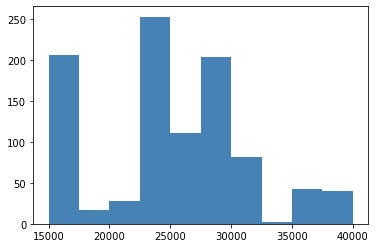

In [6]:
# Show the distribution of the dataset
X, y = separate_Xy(df_raw)
ax = plt.subplot()
plt.hist(y, color='steelblue')
plt.show()

In [7]:
# Seperate y into 3 groups
def separate_y(y):
    y_n = copy.deepcopy(y)
    for i in range(len(y)):
        if y[i] < 20000:
            y_n[i] = '< 20000'
        elif (y[i] >= 20000) and (y[i] < 32500):
            y_n[i] = '20000 to 32500'
        else:
            y_n[i] = '> 32500'
    return y_n

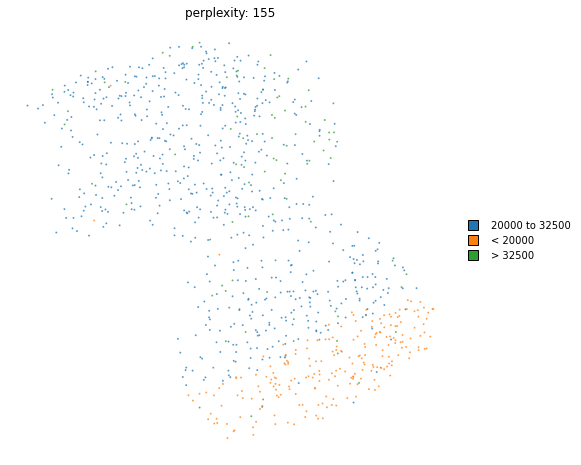

In [8]:
best_score = float('-inf')
best_embedding = None
best_perplexity = 0
y_n = separate_y(y)
for i in range(16, 160):
    tsne = TSNE(n_components=3, perplexity=i, early_exaggeration_iter=500, early_exaggeration=12, n_iter=1000, \
                    initialization='pca', metric='euclidean', n_jobs=-1, neighbors='auto', random_state=42, verbose=False)
    embedding = tsne.fit(X)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(embedding)
    score = kmeans.score(embedding)
    if score > best_score:
        best_score = copy.deepcopy(score)
        best_embedding = copy.deepcopy(embedding)
        best_perplexity = copy.deepcopy(i)
plot(best_embedding, y_n, title='perplexity: '+str(best_perplexity))

## Training Models

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.utils import resample